In [153]:
!pip install pycountry
!pip install cufflinks
!pip install folium


# Import the necessary Libraries

In [356]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pycountry
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
!pip install chart_studio
import chart_studio.plotly as py
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

#Geographical Plotting
import folium
from folium import Choropleth, Circle, Marker
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster

!pip install bar_chart_race
import bar_chart_race as bcr
from IPython.display import HTML


plt.rcParams['figure.figsize'] = 8, 5
plt.style.use("fivethirtyeight")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

In [445]:
city_day = pd.read_csv('city_day.csv')
cities_db = pd.read_csv('Indian Cities Database.csv')

# <a> 1. A first look at City level- daily data</a>

In [447]:
display("CITY DAILY DATA")
display(city_day.head(5))

'CITY DAILY DATA'

City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  01-01-2019    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  02-01-2019    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  03-01-2019    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  04-01-2019    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  05-01-2019    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN

In [449]:
city_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


## <a> 1.1 Missing Values </a>

In [451]:
def missing_values_table(df):

        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

missing_values= missing_values_table(city_day)
missing_values.style.background_gradient(cmap='Reds')

Your selected dataframe has 16 columns.
There are 14 columns that have missing values.


## <a> 1.2 Cities in the dataset</a>

In [453]:
cities = city_day['City'].value_counts()
print(f'Total number of cities in the dataset : {len(cities)}')
print(cities.index)

Total number of cities in the dataset : 26
Index(['Ahmedabad', 'Delhi', 'Mumbai', 'Bengaluru', 'Lucknow', 'Chennai',
       'Hyderabad', 'Patna', 'Gurugram', 'Visakhapatnam', 'Amritsar',
       'Jorapokhar', 'Jaipur', 'Thiruvananthapuram', 'Amaravati',
       'Brajrajnagar', 'Talcher', 'Kolkata', 'Guwahati', 'Coimbatore',
       'Shillong', 'Chandigarh', 'Bhopal', 'Ernakulam', 'Kochi', 'Aizawl'],
      dtype='object', name='City')


## <a> 1.3 Convert to Date Time format</a>

In [455]:
city_day['Date'] = pd.to_datetime(city_day['Date'], format='%d-%m-%Y')

## <a> 1.4 Data Availability</a>

In [457]:
print(f"The available data is between {city_day['Date'].min()} and {city_day['Date'].max()}")

The available data is between 2019-01-01 00:00:00 and 2024-07-01 00:00:00


# <a>2. Analyse the complete City Level Daily Data</a>

## <a> 2.1 Combining the Benzene, Toluene and Xylene levels into one column</a>

In [459]:
city_day['BTX'] = city_day['Benzene']+city_day['Toluene']+city_day['Xylene']
city_day.drop(['Benzene','Toluene','Xylene'],axis=1);

## <a> 2.2 Combining the PM2.5 and PM10 into one column - Particulate Matter</a>

In [461]:
city_day['Particulate_Matter'] = city_day['PM2.5']+city_day['PM10']

## <a> 2.3 Subsetting columns</a>

In [463]:
pollutants = ['PM2.5','PM10','NO2', 'CO', 'SO2','O3', 'BTX']

## <a> 2.3 Visualising yearly data </a>

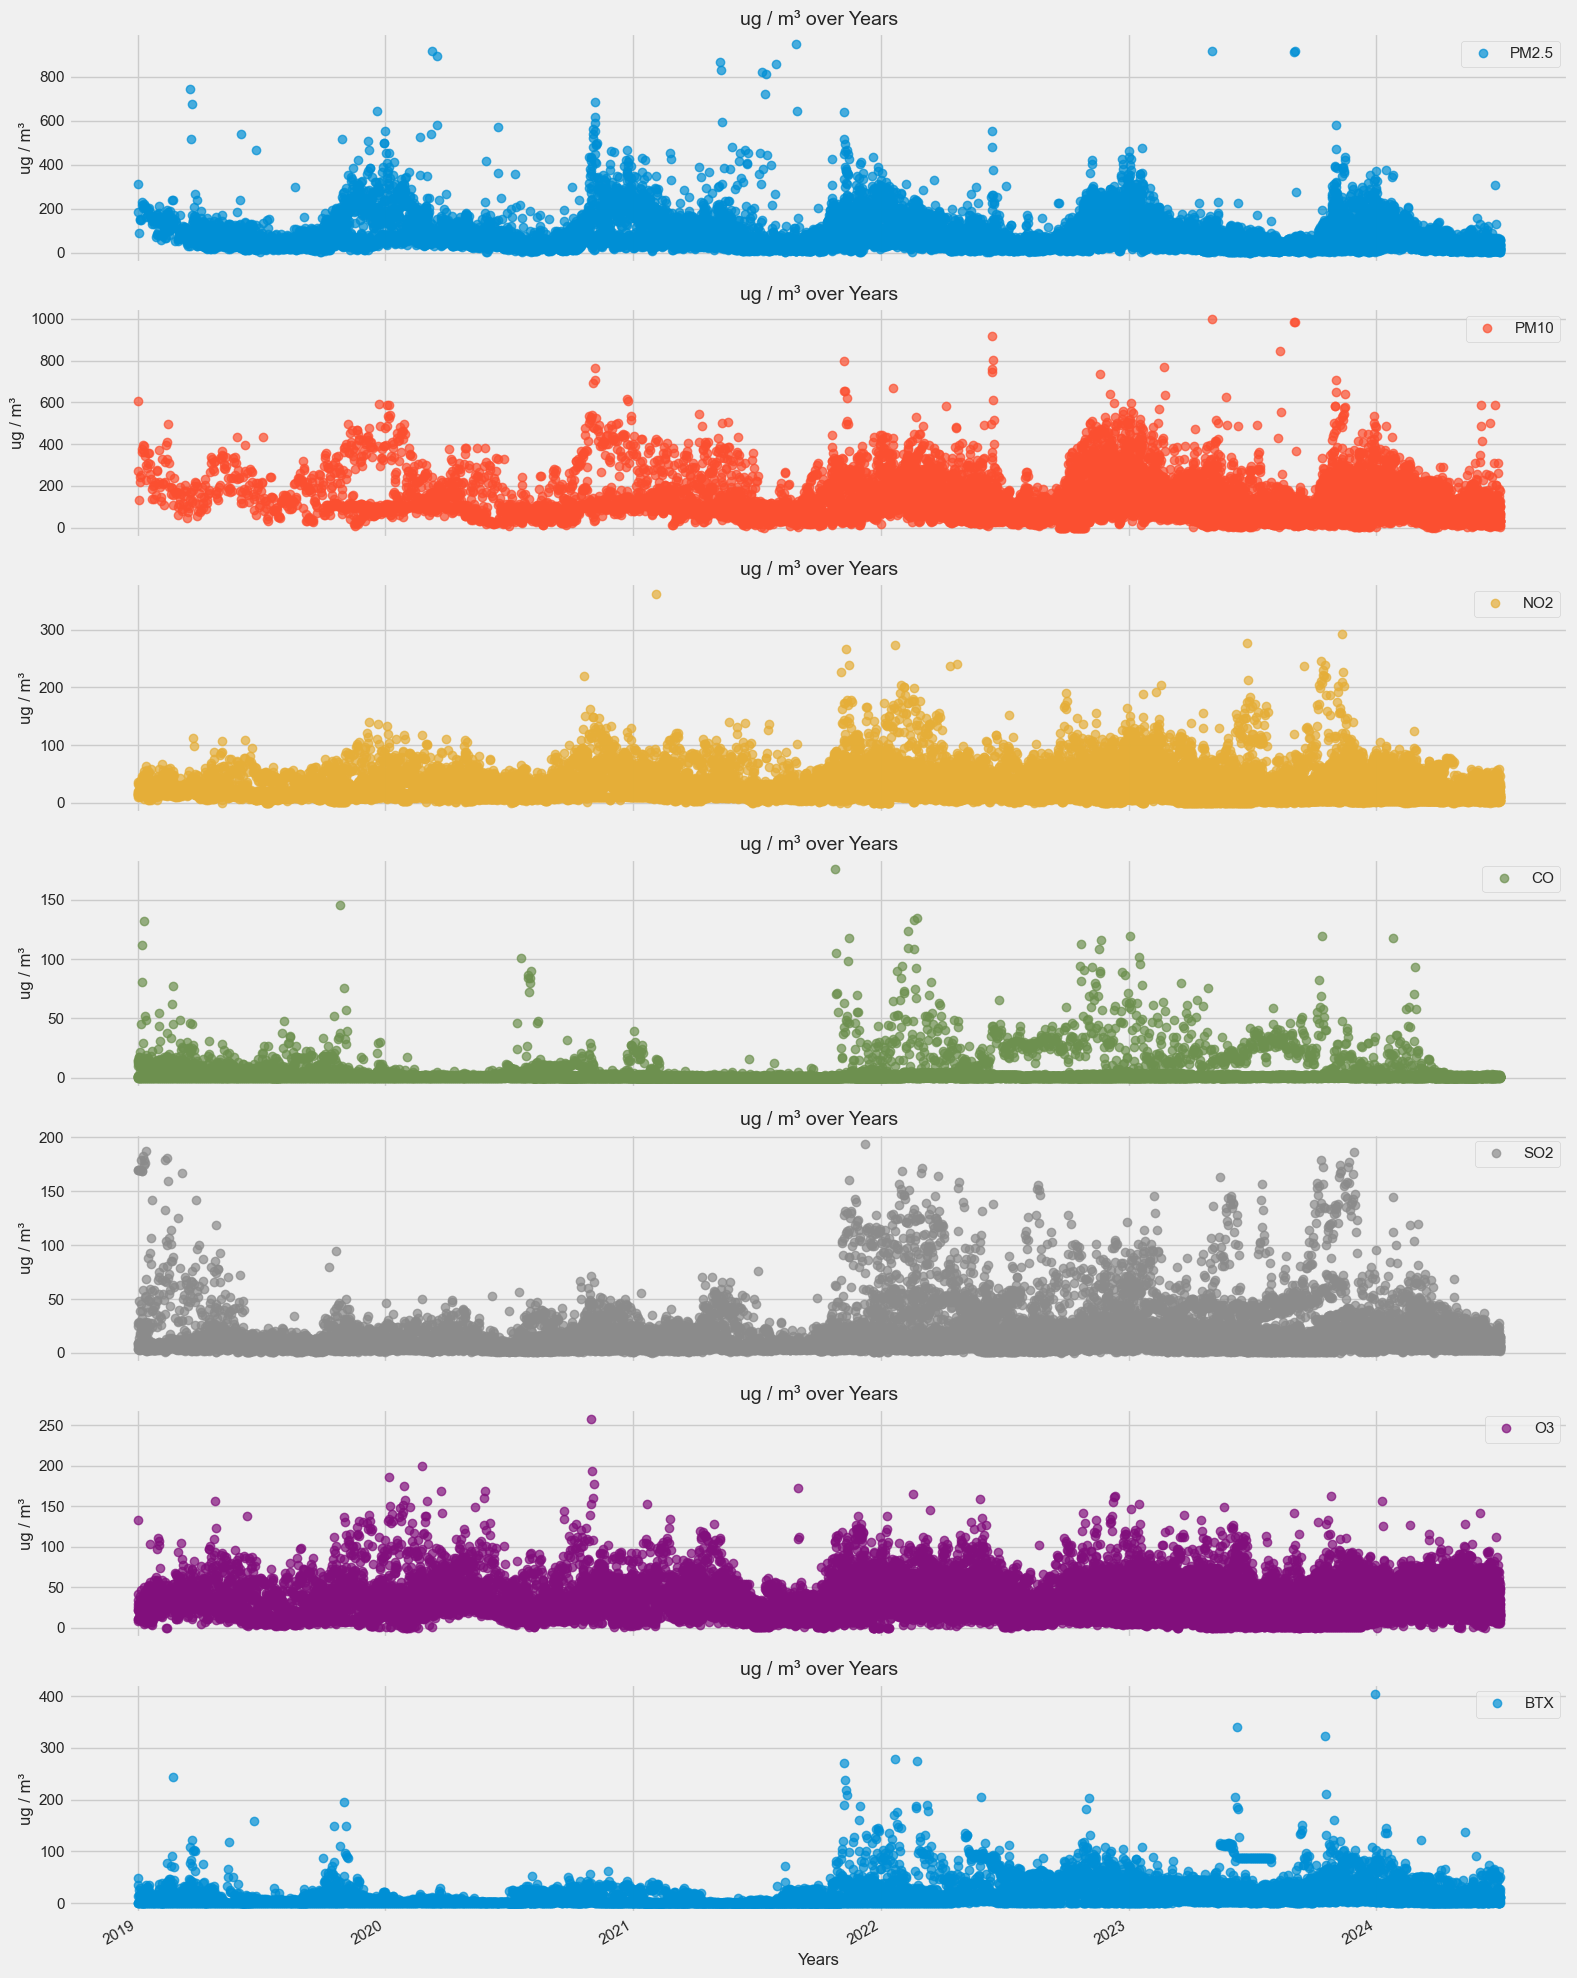

In [465]:
city_day.set_index('Date', inplace=True)

axes = city_day[pollutants].plot(marker='o', alpha=0.7, linestyle='None', figsize=(16, 20), subplots=True)

for ax in axes:
    ax.set_xlabel('Years', fontsize=12)
    ax.set_ylabel('ug / m³', fontsize=12)
    ax.grid(True)
    ax.set_title(f"{ax.get_ylabel()} over Years", fontsize=14)

plt.tight_layout()
plt.show()

In [467]:
def trend_plot(dataframe,value):
    
    # Prepare data
    df['year'] = [d.year for d in df.Date]
    df['month'] = [d.strftime('%b') for d in df.Date]
    years = df['year'].unique()

    # Draw Plot
    fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi= 80)
    sns.boxplot(x='year', y=value, data=df, ax=axes[0])
    sns.pointplot(x='month', y=value, data=df.loc[~df.year.isin([2015, 2020]), :])

    # Set Title
    axes[0].set_title('Year-wise Box Plot \n(The Trend)', fontsize=18); 
    axes[1].set_title('Month-wise Plot \n(The Seasonality)', fontsize=18)
    plt.show()


## <a> 2.4 Year and Month wise distribution </a>
All measurements are in `µg/m³` stands for micrograms per cubic meter.
### <a> 2.4.1 NO<sub>2</sub> </a>

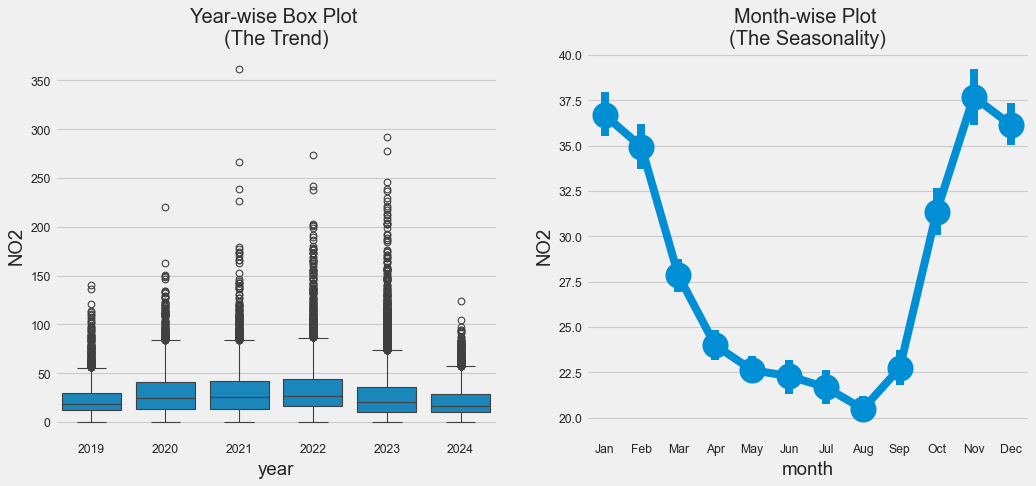

In [469]:
city_day.reset_index(inplace=True)
df = city_day.copy()
value='NO2'
trend_plot(df,value)

### <a> 2.4.2 SO<sub>2</sub> </a>

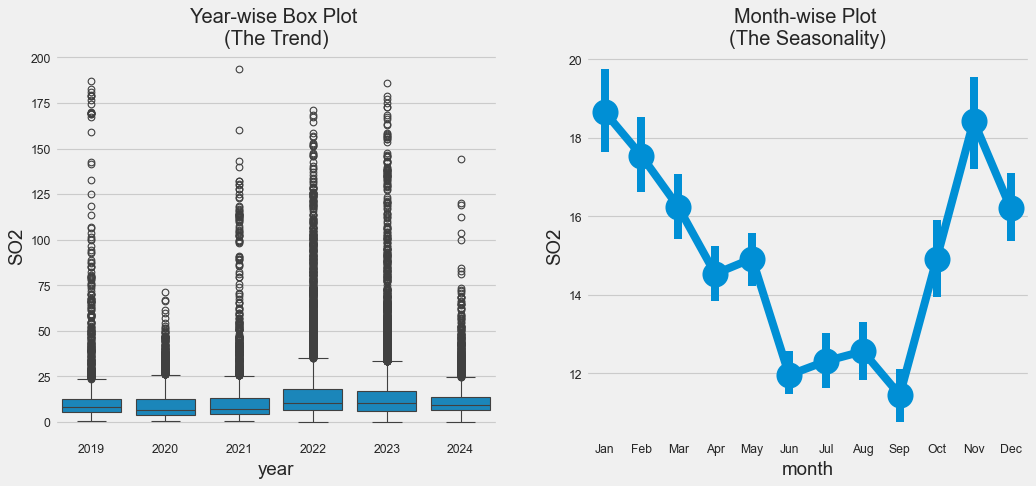

In [199]:
df = city_day.copy()
value='SO2'
trend_plot(df,value)

### <a> 2.4.3 BTX </a>

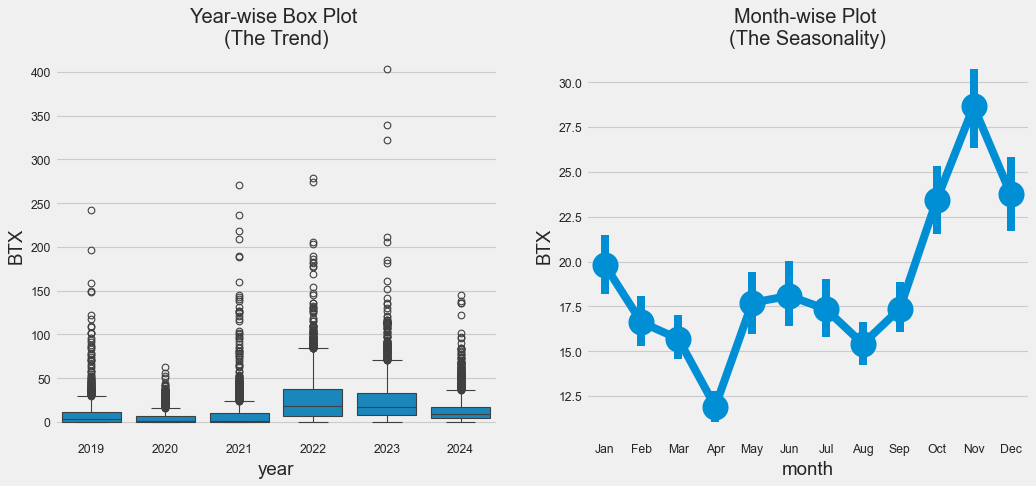

In [473]:
value='BTX'
trend_plot(df,value)

### <a> 2.4.4 PM2.5 </a>

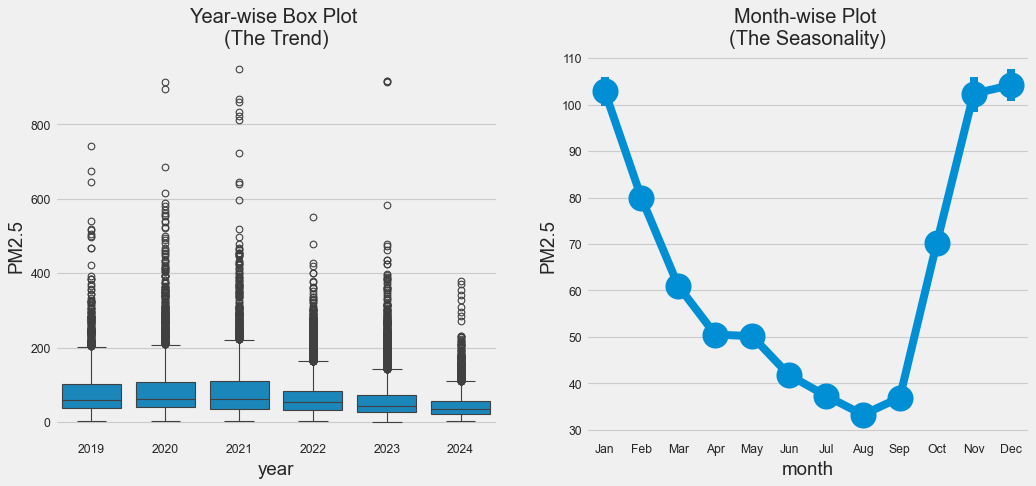

In [476]:
value='PM2.5'
trend_plot(df,value)

### <a> 2.4.5 PM10 </a>

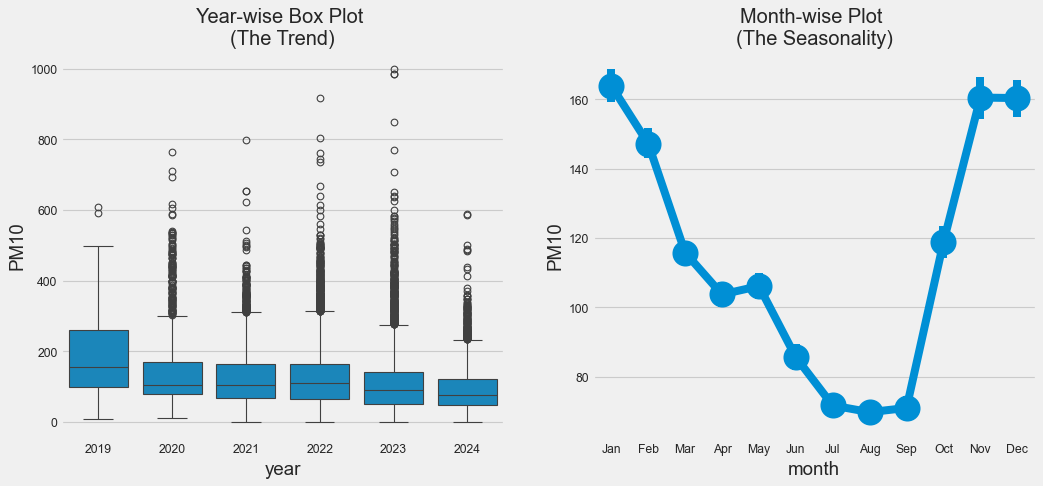

In [479]:
value='PM10'
trend_plot(df,value)

# <a> 3. Most Polluted Indian Cities </a>

In [482]:
from IPython.display import display, HTML

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()  # Convert each Styler object to HTML
    display(HTML(html_str.replace('table', 'table style="display:inline"')))


In [484]:
def max_polluted_city(pollutant):
    x1 = city_day[[pollutant, 'City']].groupby(["City"]).mean().sort_values(by=pollutant, ascending=False).reset_index()
    x1[pollutant] = round(x1[pollutant], 2)
    return x1.style.background_gradient(cmap='OrRd')

    

In [486]:
pm2_5 = max_polluted_city('PM2.5')
pm10 = max_polluted_city('PM10')
no2 = max_polluted_city('NO2')
so2 = max_polluted_city('SO2')
co = max_polluted_city('CO')
btx = max_polluted_city('BTX')

display_side_by_side(pm2_5, pm10, no2, so2, co, btx)


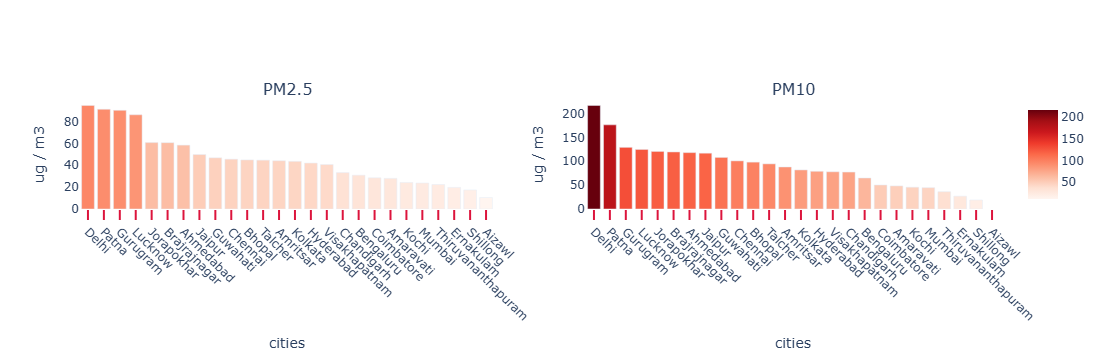

In [488]:
x2= city_day[['PM2.5','City']].groupby(["City"]).median().sort_values(by='PM2.5',ascending=False).reset_index()
x3 = city_day[['PM10','City']].groupby(["City"]).median().sort_values(by='PM10',ascending=False).reset_index()

from plotly.subplots import make_subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("PM2.5","PM10"))

fig.add_trace(go.Bar( y=x2['PM2.5'], x=x2["City"],  
                     marker=dict(color=x2['PM2.5'], coloraxis="coloraxis")),
              1, 1)


fig.add_trace(go.Bar( y=x3['PM10'], x=x2["City"],  
                     marker=dict(color=x3['PM10'], coloraxis="coloraxis")),
              1, 2)
fig.update_layout(coloraxis=dict(colorscale='reds'), showlegend=False,plot_bgcolor='white')
fig.update_xaxes(ticks="outside", tickwidth=2,tickangle=45, tickcolor='crimson', ticklen=10,title_text="cities")
fig.update_yaxes(title_text="ug / m3", row=1, col=1)
fig.update_yaxes(title_text="ug / m3", row=1, col=2)
fig.show()

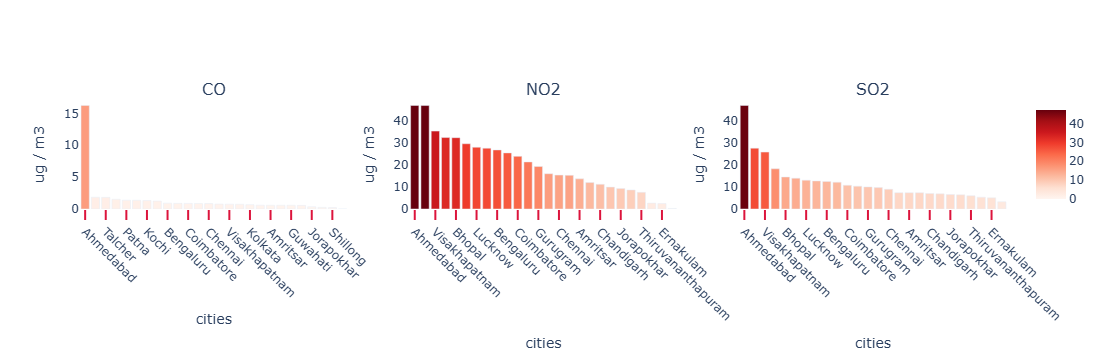

In [490]:
x4= city_day[['CO','City']].groupby(["City"]).median().sort_values(by='CO',ascending=False).reset_index()
x5 = city_day[['NO2','City']].groupby(["City"]).median().sort_values(by='NO2',ascending=False).reset_index()
x6 = city_day[['SO2','City']].groupby(["City"]).median().sort_values(by='SO2',ascending=False).reset_index()


from plotly.subplots import make_subplots
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=("CO","NO2",'SO2'))

fig.add_trace(go.Bar( y=x4['CO'], x=x4["City"],  
                     marker=dict(color=x4['CO'], coloraxis="coloraxis")),
              1, 1)


fig.add_trace(go.Bar( y=x5['NO2'], x=x5["City"],  
                     marker=dict(color=x5['NO2'], coloraxis="coloraxis")),
              1, 2)

fig.add_trace(go.Bar( y=x6['SO2'], x=x5["City"],  
                     marker=dict(color=x6['SO2'], coloraxis="coloraxis")),
              1, 3)
fig.update_layout(coloraxis=dict(colorscale='reds'), showlegend=False,plot_bgcolor='white')
fig.update_xaxes(ticks="outside", tickwidth=2,tickangle=45, tickcolor='crimson', ticklen=10,title_text="cities")
fig.update_yaxes(title_text="ug / m3", row=1, col=1)
fig.update_yaxes(title_text="ug / m3", row=1, col=2)
fig.update_yaxes(title_text="ug / m3", row=1, col=3)
fig.show()

# <a>4. Effect of Harmful Gas on AQI</a>

## <a>4.1 AQI : Air Quality Index</a>
An air quality index (AQI) is used by government agencies to communicate to the public how polluted the air currently is or how polluted it is forecast to become.There are six AQI categories, namely Good, Satisfactory, Moderately polluted, Poor, Very Poor, and Severe. The proposed AQI will consider eight pollutants (PM10, PM2.5, NO2, SO2, CO, O3, NH3, and Pb) for which short-term (up to 24-hourly averaging period) National Ambient Air Quality Standards are prescribed. Based on the measured ambient concentrations, corresponding standards and likely health impact, a sub-index is calculated for each of these pollutants. The worst sub-index reflects overall AQI. Likely health impacts for different AQI categories and pollutants have also been suggested, with primary inputs from the medical experts in the group. The AQI values and corresponding ambient concentrations (health breakpoints) as well as associated likely health impacts for the identified eight pollutants are as follows:[[Wikipedia](https://en.wikipedia.org/wiki/Air_quality_index)]

## <a>4.2 AQI for some of the major cities of India</a>

In [495]:
cities = ['Ahmedabad','Delhi','Bengaluru','Mumbai','Hyderabad','Chennai']

filtered_city_day = city_day[city_day['Date'] >= '2023-01-01']
AQI = filtered_city_day[filtered_city_day.City.isin(cities)][['Date','City','AQI','AQI_Bucket']]
AQI.head()

Date       City     AQI AQI_Bucket
1461 2023-01-01  Ahmedabad  1474.0     Severe
1462 2023-01-02  Ahmedabad  1246.0     Severe
1463 2023-01-03  Ahmedabad  1719.0     Severe
1464 2023-01-04  Ahmedabad  1264.0     Severe
1465 2023-01-05  Ahmedabad  1127.0     Severe

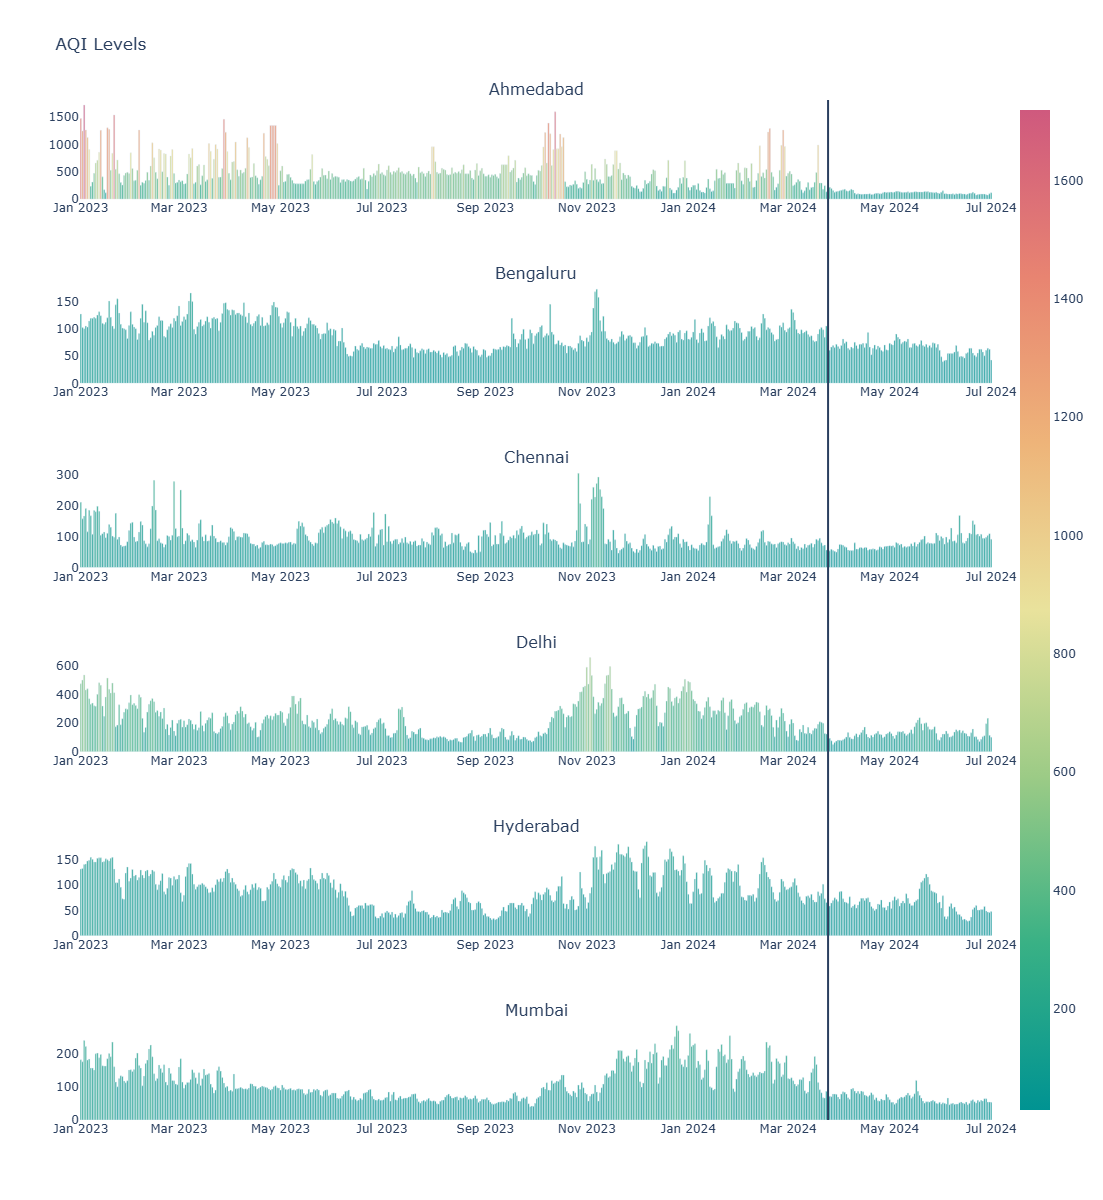

In [497]:
AQI_pivot = AQI.pivot(index='Date', columns='City', values='AQI')
AQI_pivot.fillna(method='bfill',inplace=True)


from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=6, cols=1,
    #specs=[[{}, {}],
          # [{"colspan": 6}, None]],
    subplot_titles=("Ahmedabad","Bengaluru","Chennai","Delhi",'Hyderabad','Mumbai'))

fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Ahmedabad'],
                    marker=dict(color=AQI_pivot['Ahmedabad'],coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Bengaluru'],
                    marker=dict(color=AQI_pivot['Bengaluru'], coloraxis="coloraxis")),
              2, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Chennai'],
                    marker=dict(color=AQI_pivot['Chennai'], coloraxis="coloraxis")),
              3, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Delhi'],
                    marker=dict(color=AQI_pivot['Delhi'], coloraxis="coloraxis")),
              4, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Hyderabad'],
                    marker=dict(color=AQI_pivot['Hyderabad'], coloraxis="coloraxis")),
              5, 1)
fig.add_trace(go.Bar(x=AQI_pivot.index, y=AQI_pivot['Mumbai'],
                    marker=dict(color=AQI_pivot['Mumbai'], coloraxis="coloraxis")),
              6, 1)

fig.update_layout(coloraxis=dict(colorscale='Temps'),showlegend=False,title_text="AQI Levels")

fig.update_layout(plot_bgcolor='white')

fig.update_layout( width=800,height=1200,shapes=[
      dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= '2024-03-25', x1= '2024-03-25'
    )
])

fig.show()

## <a> 4.3 AQI before and after 2023 </a>

In [504]:
AQI_before2023 = AQI_pivot['2024-01-01':'2024-03-25']
AQI_after2024 = AQI_pivot['2024-03-26':'2024-05-01']

In [506]:
print(AQI_before2023.mean())
print(AQI_after2024.mean())

City
Ahmedabad    383.776471
Bengaluru     96.023529
Chennai       80.317647
Delhi        246.305882
Hyderabad     94.435294
Mumbai       148.776471
dtype: float64
City
Ahmedabad    127.810811
Bengaluru     68.486486
Chennai       62.351351
Delhi        107.270270
Hyderabad     65.567568
Mumbai        73.891892
dtype: float64


In [508]:
from matplotlib.patches import Circle, Wedge, Rectangle

def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

In [510]:
from matplotlib.patches import Circle, Wedge, Rectangle
def gauge(labels=['GOOD','SATISFACTORY','MODERATE','POOR','VERY POOR','EXTREME'], \
          colors='jet_r', arrow=1, title='', fname=False): 
    
    """
    some sanity checks first
    

"""
    
    N = len(labels)
    
    if arrow > N: 
        raise Exception("\n\nThe category ({}) is greated than \
        the length\nof the labels ({})".format(arrow, N))
 
    
    """
    if colors is a string, we assume it's a matplotlib colormap
    and we discretize in N discrete colors 
    """
    
    if isinstance(colors, str):
        cmap = cm.get_cmap(colors, N)
        cmap = cmap(np.arange(N))
        colors = cmap[::-1,:].tolist()
    if isinstance(colors, list): 
        if len(colors) == N:
            colors = colors[::-1]
        else: 
            raise Exception("\n\nnumber of colors {} not equal \
            to number of categories{}\n".format(len(colors), N))

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(N)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, title, horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = mid_points[abs(arrow - N)]
    
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)

"Ahmedabad's AQI levels"

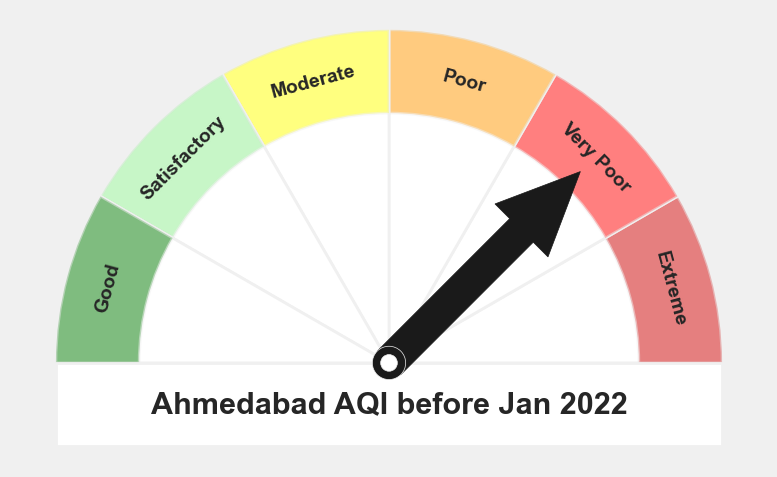

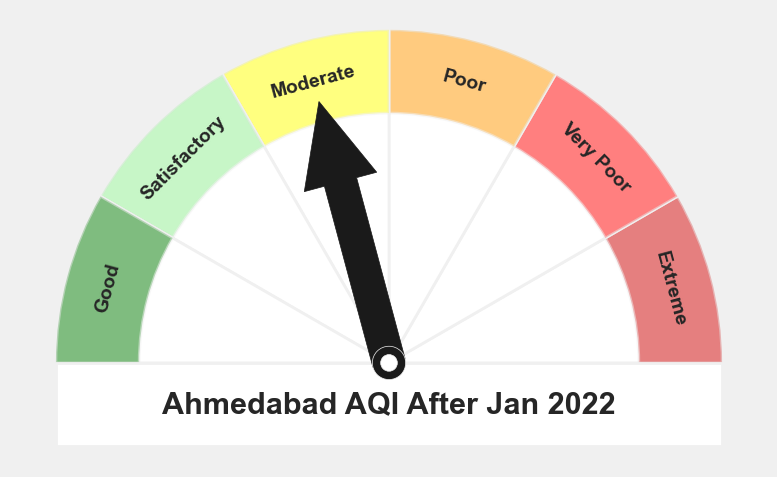

In [512]:
display("Ahmedabad's AQI levels")

gauge(labels=['Good','Satisfactory','Moderate','Poor','Very Poor','Extreme'], \
      colors=['#007A00','#90EE90','#ffff00','#FF9900','#ff0000','#CC0000'], arrow=5, title='Ahmedabad AQI before Jan 2022') 

gauge(labels=['Good','Satisfactory','Moderate','Poor','Very Poor','Extreme'], \
      colors=['#007A00','#90EE90','#ffff00','#FF9900','#ff0000','#CC0000'], arrow=3, title='Ahmedabad AQI After Jan 2022') 

"Delhi's AQI levels"

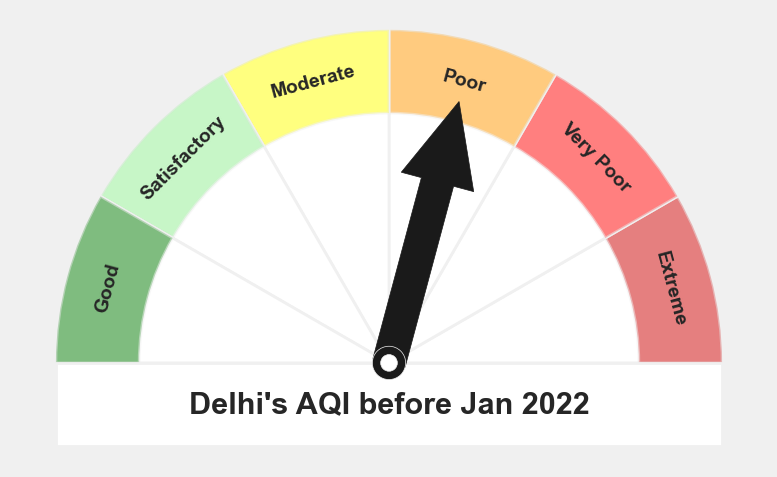

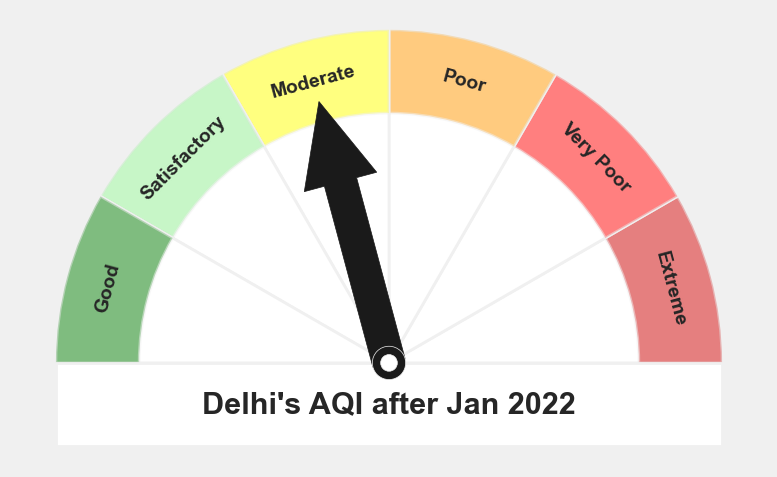

In [514]:
display("Delhi's AQI levels")

gauge(labels=['Good','Satisfactory','Moderate','Poor','Very Poor','Extreme'], \
      colors=['#007A00','#90EE90','#ffff00','#FF9900','#ff0000','#CC0000'], arrow=4, title="Delhi's AQI before Jan 2022") 

gauge(labels=['Good','Satisfactory','Moderate','Poor','Very Poor','Extreme'], \
      colors=['#007A00','#90EE90','#ffff00','#FF9900','#ff0000','#CC0000'], arrow=3, title="Delhi's AQI after Jan 2022") 


"Mumbai's AQI levels"

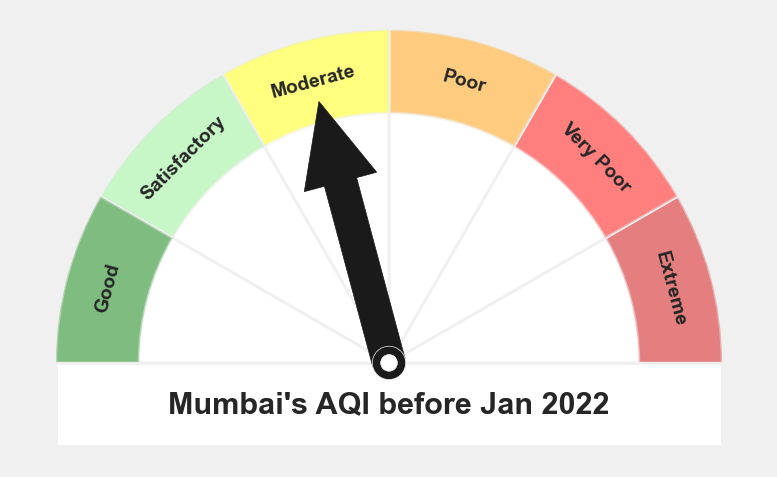

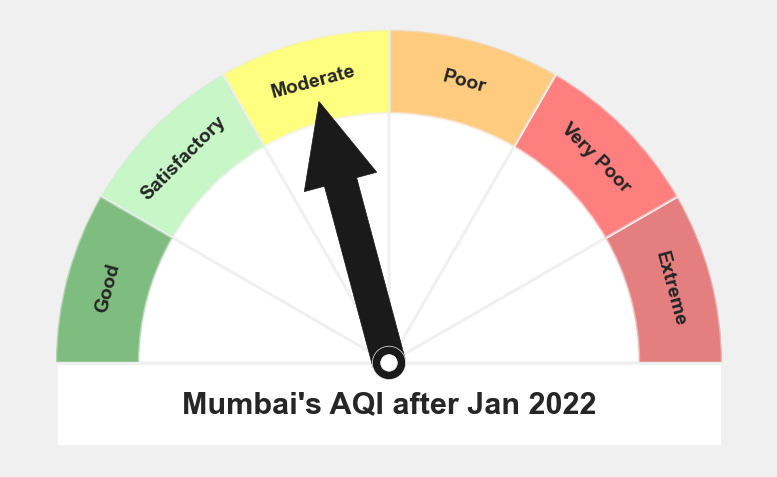

In [516]:
display("Mumbai's AQI levels")

gauge(labels=['Good','Satisfactory','Moderate','Poor','Very Poor','Extreme'], \
      colors=['#007A00','#90EE90','#ffff00','#FF9900','#ff0000','#CC0000'], arrow=3, title="Mumbai's AQI before Jan 2022") 

gauge(labels=['Good','Satisfactory','Moderate','Poor','Very Poor','Extreme'], \
      colors=['#007A00','#90EE90','#ffff00','#FF9900','#ff0000','#CC0000'], arrow=3, title="Mumbai's AQI after Jan 2022") 



# <a> 5 Effect of Harmful Gases on levels of Individual pollutants <a> 

## <a> 5.1 A comparison between pollution levels in 2023 VS 2024    

In [519]:
start_date1 = '2023-01-01'
end_date1 = '2023-05-01'

mask1 = (city_day['Date'] >= start_date1) & (city_day['Date']  <= end_date1)
pollutants_filtered_2023 = city_day.loc[mask1]
pollutants_filtered_2023.fillna(method='bfill',inplace=True)
pollutants_filtered_2023.set_index('Date',inplace=True);

start_date2 = '2024-01-01'
end_date2 = '2024-05-01'

mask2 = (city_day['Date'] >= start_date2) & (city_day['Date']  <= end_date2)
pollutants_filtered_2024 = city_day.loc[mask2]
pollutants_filtered_2024.fillna(method='bfill',inplace=True)
pollutants_filtered_2024.set_index('Date',inplace=True);


df1 = pollutants_filtered_2023[pollutants_filtered_2023.City.isin(cities)][['City','NO2','SO2','PM2.5','CO']]
df2 = pollutants_filtered_2024[pollutants_filtered_2024.City.isin(cities)][['City','NO2','SO2','PM2.5','CO']]

In [521]:
def pollution_comparison(city):
    """
    Function to plot graph comparing pollutin levels between (Jan-May)2023 and (Jan-May)2024
    
    """
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df1.index, y=df1[df1['City']==city]['NO2'],
                    line=dict(dash='solid',color='green'),name='NO2'))
    fig.add_trace(go.Scatter(x=df1.index, y=df1[df1['City']==city]['SO2'],
                    line=dict(dash='dot',color='red'),name='SO2'))
    fig.add_trace(go.Scatter(x=df1.index, y=df1[df1['City']==city]['PM2.5'],
                    line=dict(dash='dashdot',color='dodgerblue'),name='Particulate_Matter'))
    fig.add_trace(go.Scatter(x=df1.index, y=df1[df1['City']==city]['CO'],
                    line=dict(dash='longdashdot'),mode='lines',name='CO'))
    fig.update_layout(title_text=city+' 2023 ',plot_bgcolor='white')
    fig.update_xaxes(rangeslider_visible=True,zeroline=True,zerolinewidth=1, zerolinecolor='Black')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df2.index, y=df2[df2['City']==city]['NO2'],
                    line=dict(dash='solid',color='green'),name='NO2'))
    fig.add_trace(go.Scatter(x=df2.index, y=df2[df2['City']==city]['SO2'],
                    line=dict(dash='dot',color='red'),name='SO2'))
    fig.add_trace(go.Scatter(x=df2.index, y=df2[df2['City']==city]['PM2.5'],
                    line=dict(dash='dashdot',color='dodgerblue'),name='Particulate_Matter'))
    fig.add_trace(go.Scatter(x=df2.index, y=df2[df2['City']==city]['CO'],
                    line=dict(dash='longdashdot'),mode='lines',name='CO'))
    fig.update_layout(title_text=city+' 2024 ',plot_bgcolor='white')
    fig.update_xaxes(rangeslider_visible=True,zeroline=True,zerolinewidth=1, zerolinecolor='Black')
    fig.show()

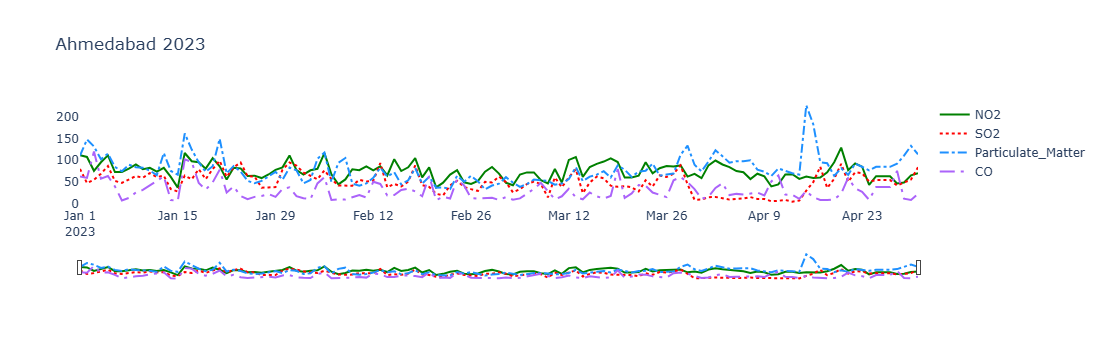

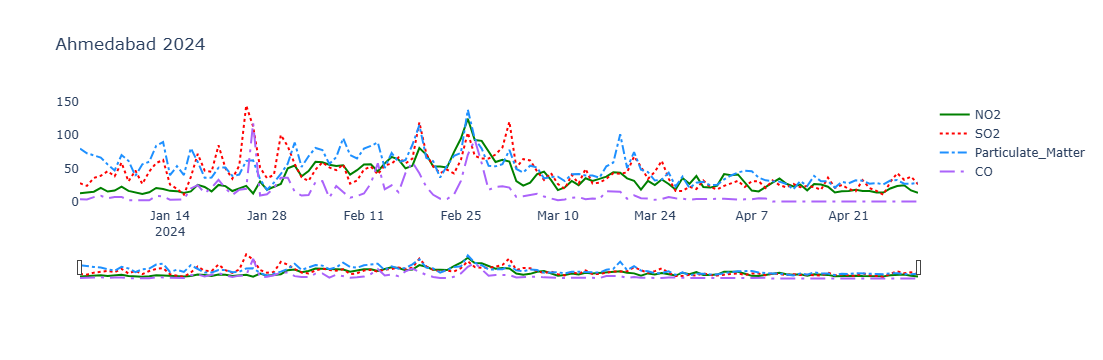

In [523]:
pollution_comparison('Ahmedabad')

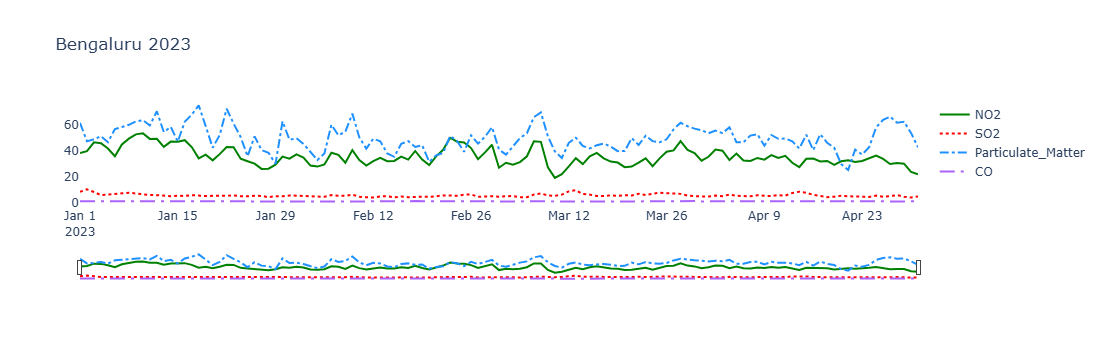

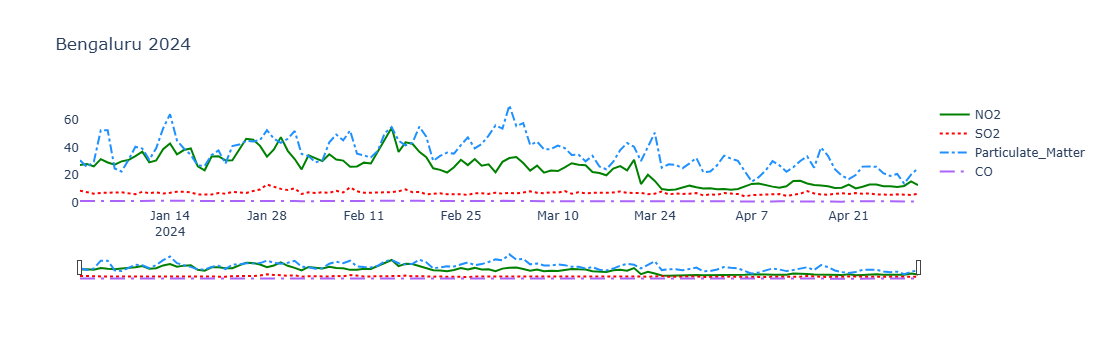

In [524]:
pollution_comparison('Bengaluru')

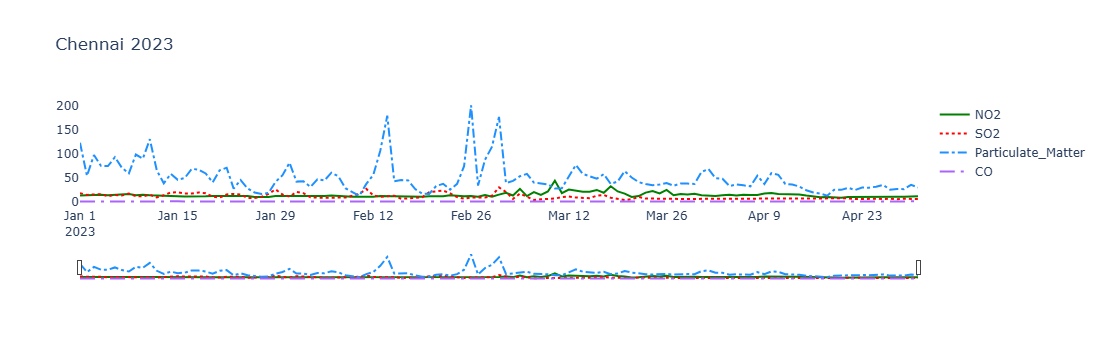

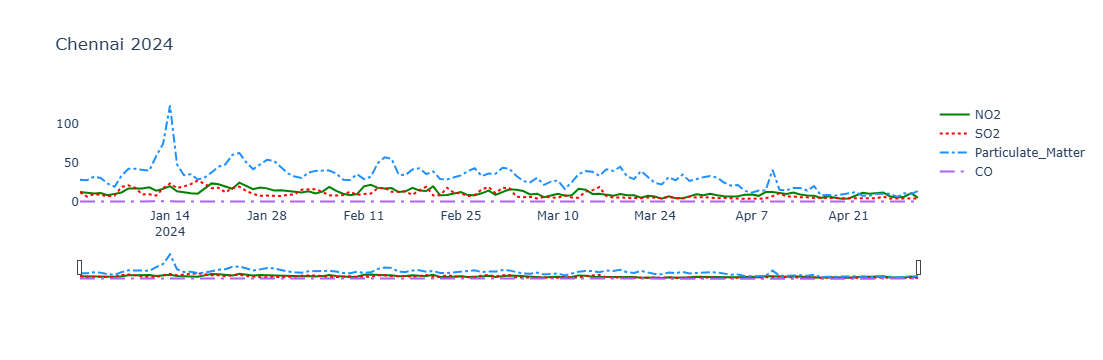

In [526]:
pollution_comparison('Chennai')

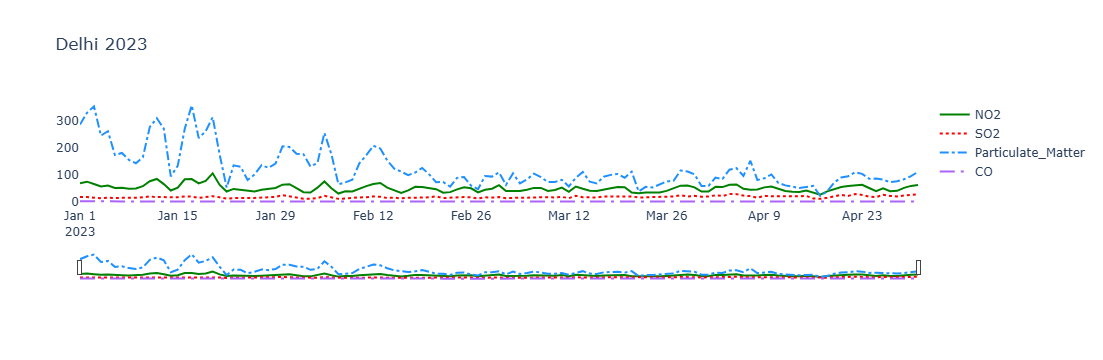

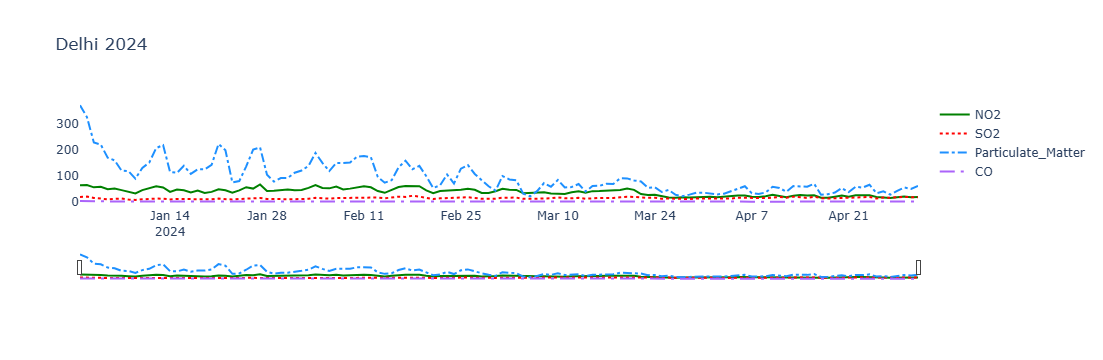

In [529]:
pollution_comparison('Delhi')

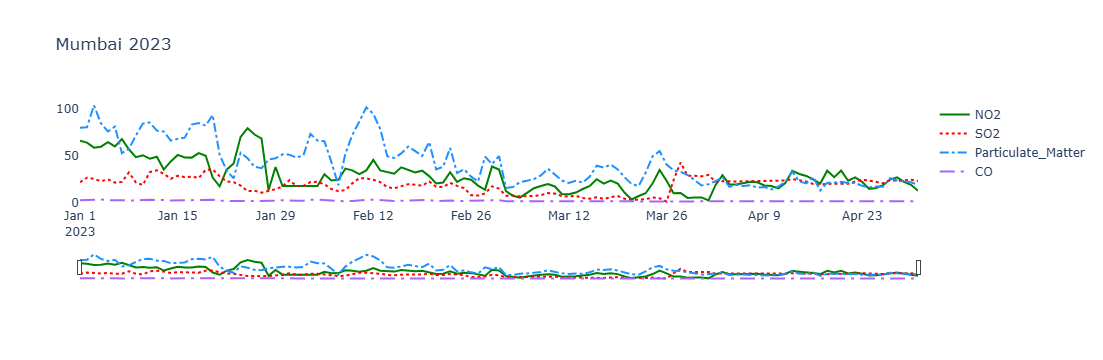

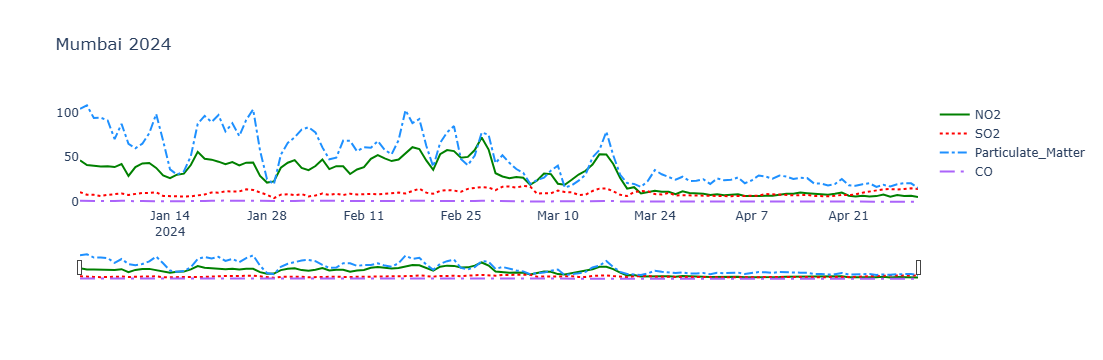

In [531]:
pollution_comparison('Mumbai')

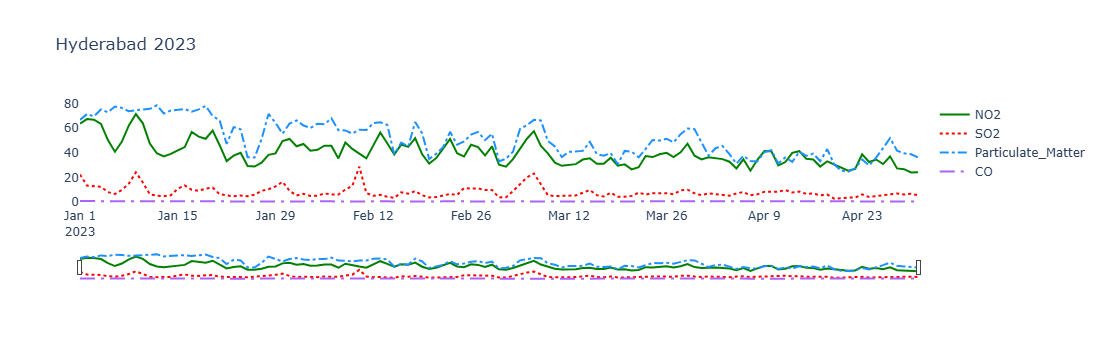

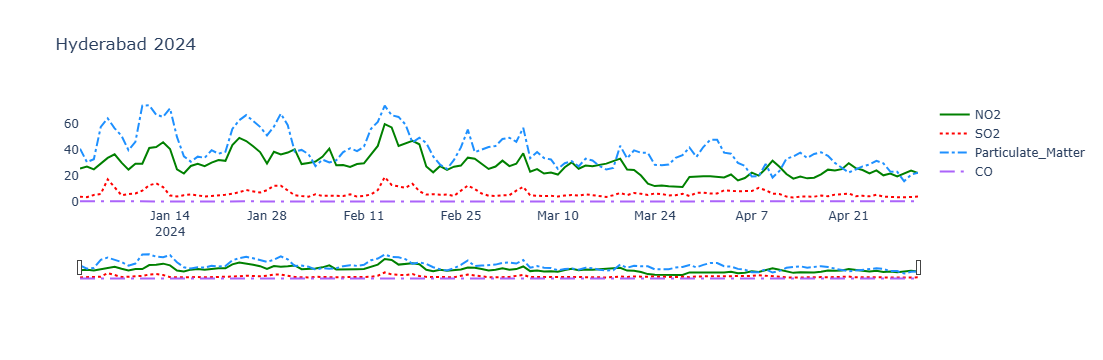

In [533]:
pollution_comparison('Hyderabad')

# <a> 6. Geographical Analysis using Dual Maps </a>

In [536]:
df11 = pollutants_filtered_2023[['City','AQI']]
df22 = pollutants_filtered_2024[['City','AQI']]

df_2019_coord = df11.groupby('City')['AQI'].mean().to_frame().reset_index()
df_2020_coord = df22.groupby('City')['AQI'].mean().to_frame().reset_index()

df_2019_AQI = pd.merge(df_2019_coord,cities_db,on='City')
df_2019_AQI['AQI'] = df_2019_AQI['AQI'].round(0)
df_2020_AQI = pd.merge(df_2020_coord,cities_db,on='City')
df_2020_AQI['AQI'] = df_2020_AQI['AQI'].round(0)

In [538]:
m = plugins.DualMap(location=(22.9734, 78.6569), tiles=None, zoom_start=5)

folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('openstreetmap').add_to(m)


fg_1 = folium.FeatureGroup(name='2022').add_to(m.m1)
fg_2 = folium.FeatureGroup(name='2024').add_to(m.m2)



for lat, lon, value, name in zip(df_2019_AQI['Lat'], df_2019_AQI['Long'], df_2019_AQI['AQI'], df_2019_AQI['City']):
    folium.CircleMarker([lat, lon],
                        radius=10,
                        icon=folium.Icon(color='red'),
                        popup = ('<strong>City</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>AQI(Average)</strong>: ' + str(value) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(fg_1)





for lat, lon, value, name in zip(df_2020_AQI['Lat'], df_2020_AQI['Long'], df_2020_AQI['AQI'], df_2020_AQI['City']):
    folium.CircleMarker([lat, lon],
                        radius=10,
                        icon=folium.Icon(color='orange'),
                        popup = ('<strong>City</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>AQI(Average)</strong>: ' + str(value) + '<br>'),
                        fill_color='orange',
                        fill_opacity=0.7 ).add_to(fg_2)


folium.LayerControl(collapsed=False).add_to(m)

m

# Average Pollution Level of Indian City

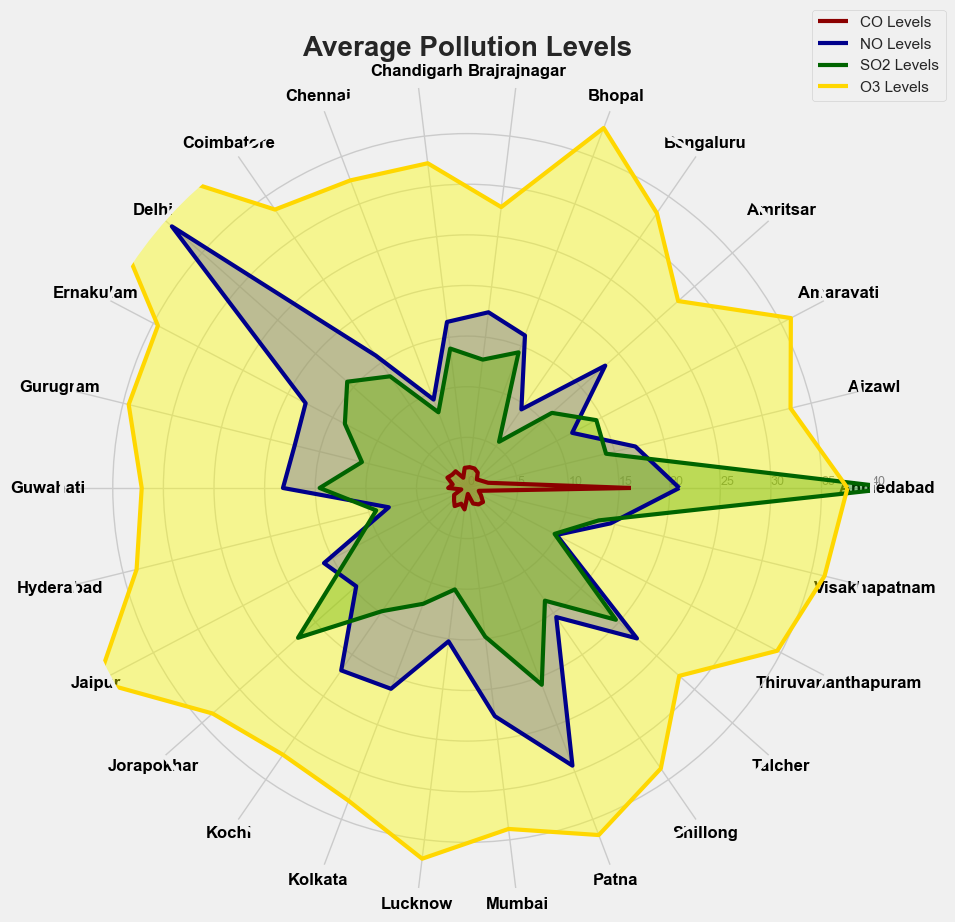

In [541]:


df_CO = city_day.pivot(index='Date', columns='City', values='CO').fillna(city_day['CO'].mean())
df_NO = city_day.pivot(index='Date', columns='City', values='NO').fillna(city_day['NO'].mean())
df_SO2 = city_day.pivot(index='Date', columns='City', values='SO2').fillna(city_day['SO2'].mean())
df_O3 = city_day.pivot(index='Date', columns='City', values='O3').fillna(city_day['O3'].mean())

categories = list(df_CO.columns)
N = len(categories)

values_co  = df_CO.mean().values.flatten()
values_no  = df_NO.mean().values.flatten()
values_so2 = df_SO2.mean().values.flatten()
values_o3  = df_O3.mean().values.flatten()


angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  

fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))


ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, color='black', size=12, fontweight='bold')


ax.set_rlabel_position(0)
ticks = np.linspace(0, 40, 9)  # More granular ticks
ax.set_yticks(ticks)
ax.set_yticklabels([str(int(x)) for x in ticks], color="grey", size=9)
ax.set_ylim(0,40)

ax.plot(angles, np.append(values_co, values_co[0]), linewidth=3, linestyle='solid', label='CO Levels', color='darkred')
ax.fill(angles, np.append(values_co, values_co[0]), color='red', alpha=0.4)

ax.plot(angles, np.append(values_no, values_no[0]), linewidth=3, linestyle='solid', label='NO Levels', color='darkblue')
ax.fill(angles, np.append(values_no, values_no[0]), color='blue', alpha=0.4)

ax.plot(angles, np.append(values_so2, values_so2[0]), linewidth=3, linestyle='solid', label='SO2 Levels', color='darkgreen')
ax.fill(angles, np.append(values_so2, values_so2[0]), color='green', alpha=0.4)

ax.plot(angles, np.append(values_o3, values_o3[0]), linewidth=3, linestyle='solid', label='O3 Levels', color='gold')
ax.fill(angles, np.append(values_o3, values_o3[0]), color='yellow', alpha=0.4)

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.title("Average Pollution Levels", fontsize=20, fontweight='bold')
plt.show()
